In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import color_palette
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv("C:/Users/USUARIO/OneDrive - SHI S.A.S/Camilo/ML/Time_Series_Forecasting/Data.csv", delimiter=";")
df['Fecha'] = pd.to_datetime(df[['Year', 'Month']].assign(Day=1))

In [3]:
df.rename(columns={"Pptn1m [mm]": "Valor"}, inplace=True)
data = df.drop(["Year","Month"], axis=1)
data= data.set_index("Fecha")

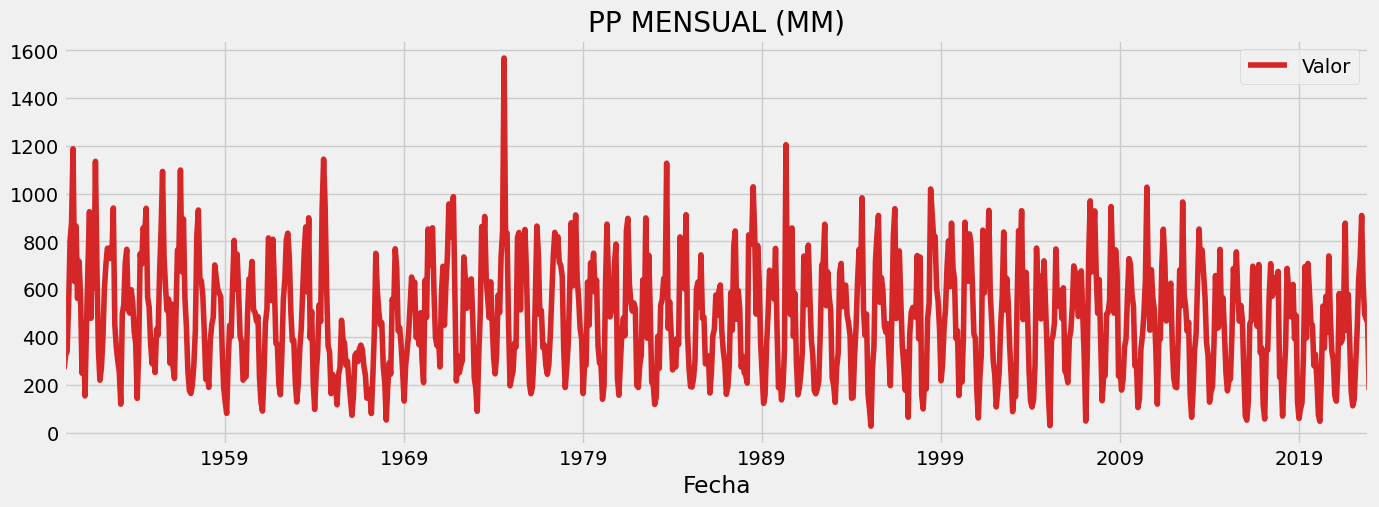

In [4]:
data.plot(style="-",
          figsize=(15,5),
          color=color_pal[3],
          title="PP MENSUAL (MM)")
plt.show()

# Train / Test Split

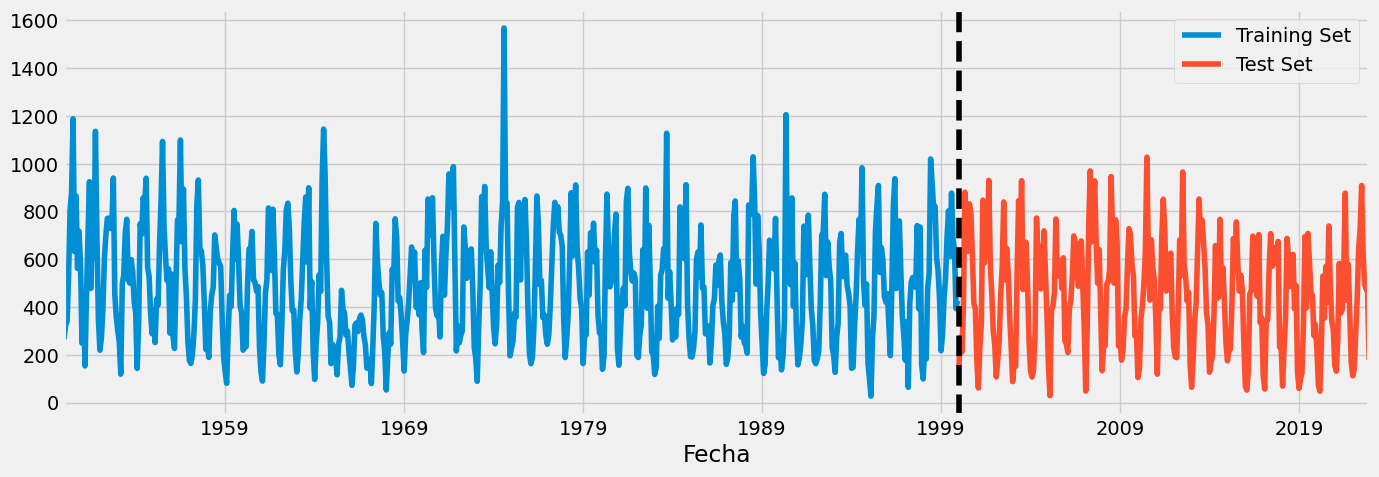

In [5]:
train= data.loc[data.index <  "2000-01-01"]
test= data.loc[data.index >=  "2000-01-01"]

fig, ax= plt.subplots( figsize=(15,5))
train.plot(ax=ax,label="Training Set")
test.plot(ax=ax, label="Test Set")
ax.axvline("2000-01-01", color="black", ls="--")
ax.legend(["Training Set","Test Set"])
plt.show()


# Feature Creation

In [13]:
def create_features(df):
    """
    Create time series Features based on time series index
    """
    df= df.copy()
    df["Month"]= df.index.month
    df["Year"]= df.index.year
    df["Quarter"]= df.index.quarter
    df["Day"]= df.index.day
    df["Dayofyear"]= df.index.dayofyear
    return df

In [14]:
data= create_features(data)

Text(0.5, 1.0, 'Ciclo Anual de Precipitación')

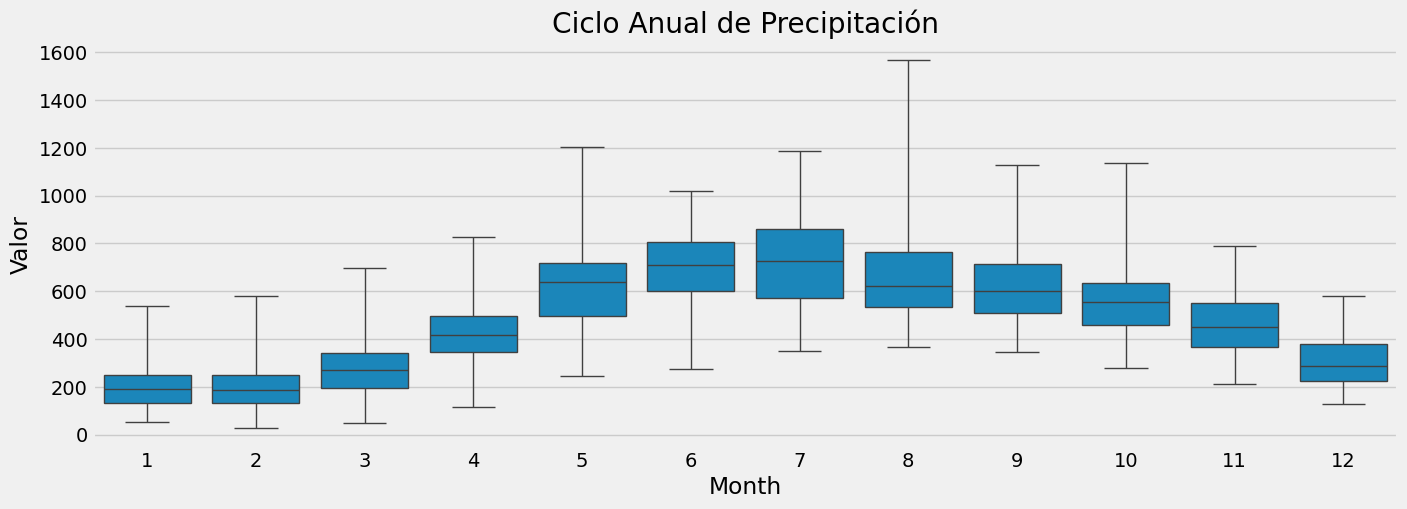

In [15]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=data, 
            x="Month",
            y="Valor",
            whis=[0,100])
plt.title("Ciclo Anual de Precipitación")

# Create a Model

In [16]:
train= create_features(train)
test= create_features(test)

In [17]:
data.columns

Index(['Valor', 'Month', 'Year', 'Quarter', 'Day', 'Dayofyear'], dtype='object')

In [18]:
FEATURES = ['Month', 'Year', 'Quarter', 'Day', 'Dayofyear']
TARGET= "Valor"

In [19]:
x_train = train[FEATURES]
y_train= train[TARGET]

x_test= test[FEATURES]
y_test= test[TARGET]

In [20]:
reg = xgb.XGBRegressor(n_estimators=10000, early_stopping_rounds=50,
                       learning_rate=0.001)
reg.fit(x_train, y_train, 
        eval_set=[(x_train,y_train),(x_test,y_test)],
        verbose=100)

[0]	validation_0-rmse:238.75653	validation_1-rmse:227.49216
[100]	validation_0-rmse:224.24057	validation_1-rmse:215.69818
[200]	validation_0-rmse:211.50240	validation_1-rmse:205.75763
[300]	validation_0-rmse:200.27685	validation_1-rmse:197.28008
[400]	validation_0-rmse:190.36952	validation_1-rmse:189.70598
[500]	validation_0-rmse:181.57094	validation_1-rmse:183.57012
[600]	validation_0-rmse:173.77801	validation_1-rmse:178.26961
[700]	validation_0-rmse:166.91302	validation_1-rmse:173.89978
[800]	validation_0-rmse:160.88338	validation_1-rmse:170.16865
[900]	validation_0-rmse:155.60394	validation_1-rmse:166.77491
[1000]	validation_0-rmse:150.96024	validation_1-rmse:163.78226
[1100]	validation_0-rmse:146.75550	validation_1-rmse:161.19674
[1200]	validation_0-rmse:142.82773	validation_1-rmse:159.17635
[1300]	validation_0-rmse:139.22271	validation_1-rmse:157.43417
[1400]	validation_0-rmse:135.90857	validation_1-rmse:156.13008
[1500]	validation_0-rmse:133.22076	validation_1-rmse:155.13159
[160

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Feature Importance

In [21]:
fi=pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=["importance"])

<Axes: title={'center': 'Feature Importance'}>

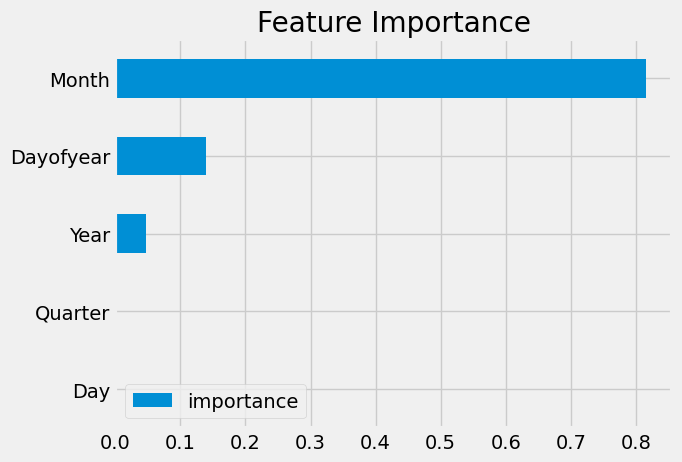

In [22]:
fi.sort_values("importance").plot(kind="barh", title="Feature Importance")

# Forecast on Test

In [23]:
test["prediction"] = reg.predict(x_test)

In [24]:
data= data.merge(test[["prediction"]], how="left", left_index=True, right_index=True)

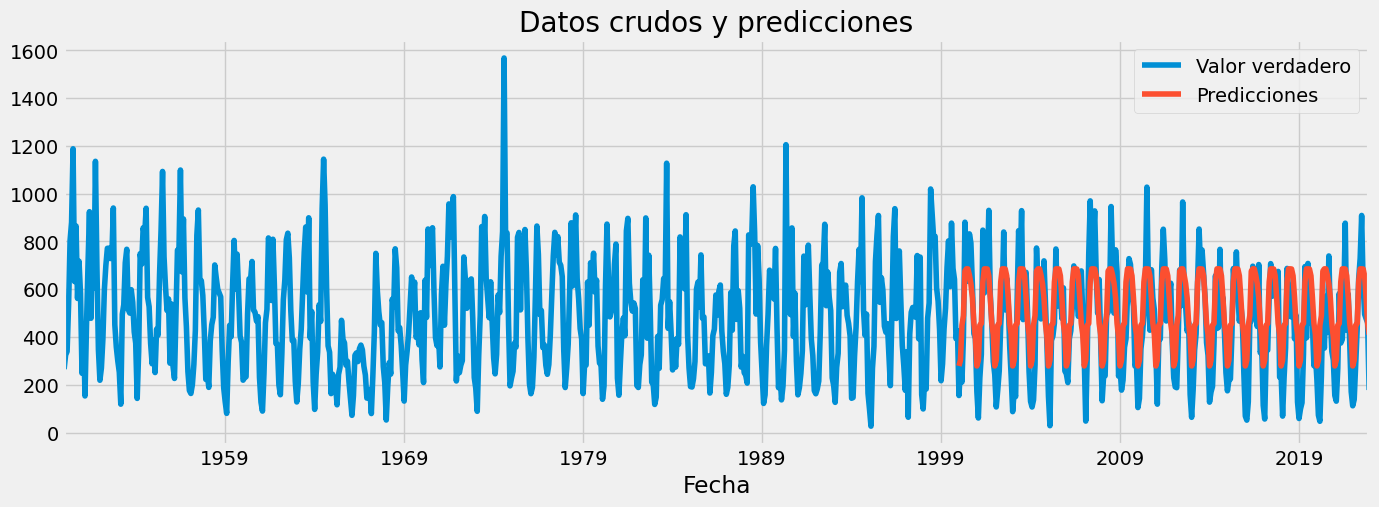

In [25]:
ax= data[["Valor"]].plot(figsize=(15,5))
data["prediction"].plot(ax=ax, style="-")
plt.legend(["Valor verdadero", "Predicciones"])
ax.set_title("Datos crudos y predicciones")
plt.show()